In [ ]:
import os
import numpy as np
!pip insert tensorflow as tf
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Add
import json
import pickle
import zipfile
import requests
from io import BytesIO

# Check GPU availability (updated to avoid AssertionError)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) == 0:
    print("⚠️ WARNING: No GPU detected! Training will be slower. Go to Runtime > Change runtime type > GPU")
else:
    print("✅ GPU is available!")


# Parameters
MAX_LENGTH = 34
VOCAB_SIZE = 3000
EMBED_DIM = 256
UNITS = 512
BATCH_SIZE = 64
EPOCHS = 30

# Download MS COCO annotations
print("Downloading captions_train2017.json...")
url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(BytesIO(response.content))
zip_file.extract("annotations/captions_train2017.json", ".")
os.rename("annotations/captions_train2017.json", "captions_train2017.json")
os.rmdir("annotations")

# Load annotations
with open('captions_train2017.json', 'r') as f:
    annotations = json.load(f)['annotations']

# Build a dictionary of image_id -> captions
image_captions = {}
for ann in annotations:
    img_id = ann['image_id']
    caption = ann['caption'].lower()
    caption = '<start> ' + caption + ' <end>'
    image_captions.setdefault(img_id, []).append(caption)

# Download a subset of train2017 images
from tqdm import tqdm

print("Downloading train2017.zip (this may take a while)...")
url = "http://images.cocodataset.org/zips/train2017.zip"
response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))
chunk_size = 1024 * 1024  # 1 MB

with open("train2017.zip", "wb") as f:
    for data in tqdm(response.iter_content(chunk_size), total=total_size // chunk_size, unit='MB'):
        f.write(data)

zip_file = zipfile.ZipFile("train2017.zip", "r")
# Extract only 1,000 images
print("Extracting 5,000 images...")
os.makedirs("train2017", exist_ok=True)
image_count = 0
for file_info in zip_file.infolist():
    if file_info.filename.endswith('.jpg'):
        zip_file.extract(file_info, ".")
        os.rename(file_info.filename, f"train2017/{file_info.filename.split('/')[-1]}")
        image_count += 1
        if image_count >= 5000:
            break

# Load image paths
image_folder = 'train2017/'
image_paths = {int(fname[:-4].split('_')[-1]): os.path.join(image_folder, fname)
               for fname in os.listdir(image_folder) if fname.endswith('.jpg')}

# Tokenizer
all_captions = [c for caps in image_captions.values() for c in caps]
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token='<unk>')
tokenizer.fit_on_texts(all_captions)
word_index = tokenizer.word_index
index_word = {v: k for k, v in word_index.items()}

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

def load_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img

# CNN Encoder using ResNet50
def build_cnn_encoder():
    base_model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
    input_img = Input(shape=(224, 224, 3))
    features = base_model(input_img)
    model = Model(inputs=input_img, outputs=features)
    return model

# RNN Decoder
class RNNDecoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super().__init__()
        self.units = units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(units, return_sequences=True, return_state=True)
        self.fc1 = Dense(units)
        self.fc2 = Dense(vocab_size)

    def call(self, features, captions):
        embeddings = self.embedding(captions)
        features = tf.expand_dims(features, 1)
        features = tf.tile(features, [1, tf.shape(captions)[1], 1])
        x = tf.concat([features, embeddings], axis=-1)
        output, _, _ = self.lstm(x)
        x = self.fc1(output)
        x = self.fc2(x)
        return x

# Prepare dataset with 5,000 images
image_ids = [img_id for img_id in image_captions.keys() if img_id in image_paths][:5000]
encoder = build_cnn_encoder()
image_features = {}
for img_id in image_ids:
    path = image_paths[img_id]
    img = load_image(path)
    img = np.expand_dims(img, axis=0)
    feature = encoder.predict(img, verbose=0)
    image_features[img_id] = feature[0]

# Prepare input-output pairs
input_seqs, target_seqs, img_feats = [], [], []
for img_id in image_ids:
    for cap in image_captions[img_id]:
        seq = tokenizer.texts_to_sequences([cap])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=MAX_LENGTH)[0]
            input_seqs.append(in_seq)
            target_seqs.append(out_seq)
            img_feats.append(image_features[img_id])

input_seqs = np.array(input_seqs)
target_seqs = np.array(target_seqs)
img_feats = np.array(img_feats)

# Build and train model
decoder = RNNDecoder(EMBED_DIM, UNITS, VOCAB_SIZE)

# Define loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

# Training step
@tf.function
def train_step(img_tensor, input_seq, target):
    with tf.GradientTape() as tape:
        predictions = decoder(img_tensor, input_seq)
        loss = loss_object(target, predictions[:, -1, :])
    grads = tape.gradient(loss, decoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, decoder.trainable_variables))
    return loss

# Training loop
for epoch in range(EPOCHS):
    total_loss = 0
    num_batches = len(input_seqs) // BATCH_SIZE
    for i in range(0, len(input_seqs), BATCH_SIZE):
        img_batch = img_feats[i:i+BATCH_SIZE]
        seq_batch = input_seqs[i:i+BATCH_SIZE]
        tgt_batch = target_seqs[i:i+BATCH_SIZE]
        loss = train_step(img_batch, seq_batch, tgt_batch)
        total_loss += loss
    avg_loss = total_loss / num_batches if num_batches > 0 else total_loss
    print(f"Epoch {epoch+1}/{EPOCHS}, Avg Loss: {avg_loss:.4f}")


ERROR: unknown command "insert" - maybe you meant "inspect"
Num GPUs Available:  1
✅ GPU is available!


18442MB [05:43, 53.76MB/s]                           


Extracting 5,000 images...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30, Avg Loss: 4.0313
Epoch 2/30, Avg Loss: 3.5292
Epoch 3/30, Avg Loss: 3.3484
Epoch 4/30, Avg Loss: 3.2382
Epoch 5/30, Avg Loss: 3.1525
Epoch 6/30, Avg Loss: 3.0875
Epoch 7/30, Avg Loss: 3.0264
Epoch 8/30, Avg Loss: 2.9779
Epoch 9/30, Avg Loss: 2.9448
Epoch 10/30, Avg Loss: 2.8991
Epoch 11/30, Avg Loss: 2.8609
Epoch 12/30, Avg Loss: 2.8318
Epoch 13/30, Avg Loss: 2.7965
Epoch 14/30, Avg Loss: 2.7522
Epoch 15/30, Avg Loss: 2.7135
Epoch 16/30, Avg Loss: 2.7051
Epoch 17/30, Avg Loss: 2.6700
Epoch 18/30, Avg Loss: 2.6583
Epoch 19/30, Avg Loss: 2.6292
Epoch 20/30, Avg Loss: 2.6106
Epoch 21/30, Avg Loss: 2.5922
Epoch 22/30, Avg Loss: 2.5789
Epoch 23/30, Avg Loss: 2.5740
Epoch 24/30, Avg Loss: 2.5625
Epoch 25/30, Avg Loss: 2.5548
Epoch 26/30, Avg Loss: 2.5411
Epoch 27/30, Avg Loss: 2.5274
Epoch 28/30, Avg Loss: 2.5209
Epoch 29/30, Avg Loss: 2.5258
Epoch 30/30, Avg Loss: 2.5120


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - kl_loss: 360.5423 - loss: 3031.6729 - reconstruction_loss: 2851.4011
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - kl_loss: 322.8242 - loss: 922.2344 - reconstruction_loss: 760.8221
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - kl_loss: 326.4992 - loss: 733.2048 - reconstruction_loss: 569.9553
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - kl_loss: 322.7322 - loss: 649.2851 - reconstruction_loss: 487.9189
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - kl_loss: 318.5035 - loss: 599.2830 - reconstruction_loss: 440.0312
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - kl_loss: 314.5066 - loss: 562.2729 - reconstruction_loss: 405.0196
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - kl_loss: 312.6297 - loss: 536.9561 - reconstruction_loss: 380.6411
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - kl_loss: 311.0819 - 

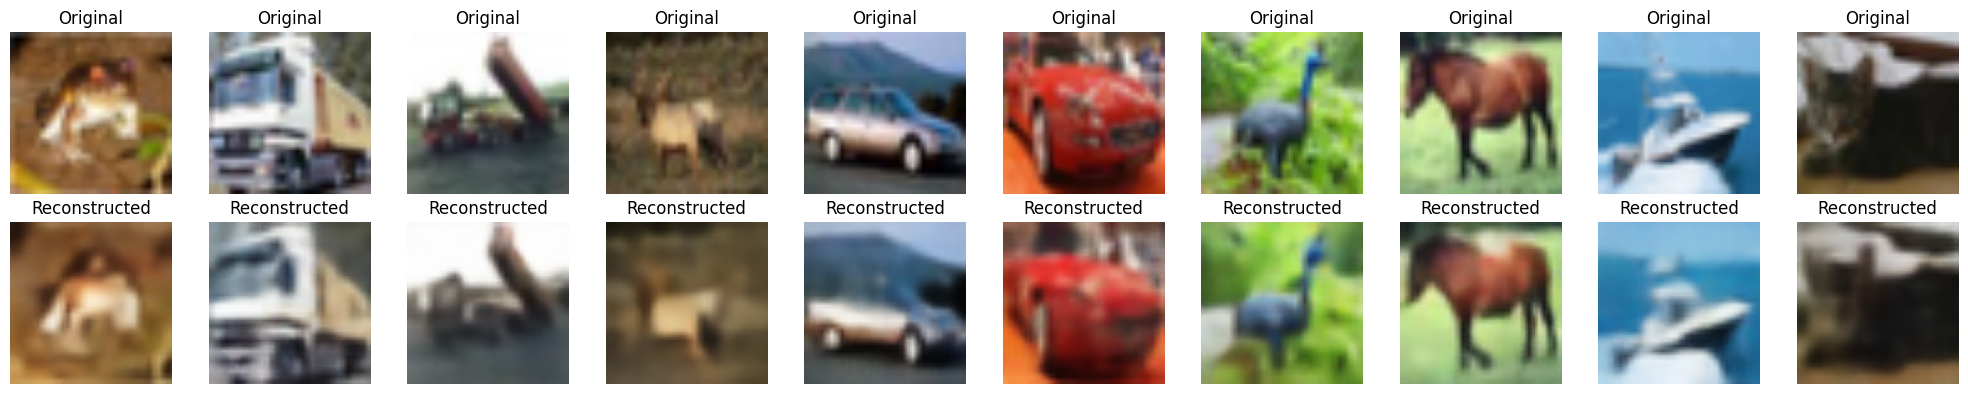

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

# Updated configuration
LATENT_DIM = 256
IMAGE_SHAPE = (128, 128, 3)
BETA = 0.5

# Encoder
def build_encoder():
    inputs = tf.keras.Input(shape=IMAGE_SHAPE)
    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(64, 3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(512, 3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
    z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
    return tf.keras.Model(inputs, [z_mean, z_log_var], name="encoder")

# Sampling
def sample_latent(z_mean, z_log_var):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Decoder
def build_decoder():
    latent_inputs = tf.keras.Input(shape=(LATENT_DIM,))
    x = layers.Dense(8 * 8 * 512, activation='relu')(latent_inputs)
    x = layers.Reshape((8, 8, 512))(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    outputs = layers.Conv2DTranspose(3, 3, activation='tanh', padding='same')(x)
    return tf.keras.Model(latent_inputs, outputs, name="decoder")

# VAE Class
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = sample_latent(z_mean, z_log_var)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = sample_latent(z_mean, z_log_var)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=(1, 2, 3)))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + BETA * kl_loss

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Load CIFAR-10 and upscale to 128x128
(x_train, _), _ = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_train = tf.image.resize(x_train, (128, 128)).numpy()
x_train = (x_train - 0.5) * 2.0  # Normalize to [-1, 1]

# Compile and train
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=100, batch_size=64)

# Visualize results
decoded_imgs = vae.predict(x_train[:10])
x_plot = (x_train[:10] + 1.0) / 2.0
decoded_plot = (decoded_imgs + 1.0) / 2.0

plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_plot[i])
    plt.title("Original")
    plt.axis("off")
    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(decoded_plot[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.tight_layout()
plt.show()



In [ ]:
import torch
import torchvision.transforms as T

# Convert to [0, 1] and then to torch.Tensor format for inference
def preprocess_generated_images(images):
    images = (images + 1.0) / 2.0  # Rescale to [0, 1]
    images = torch.from_numpy(images).permute(0, 3, 1, 2).float()  # [B, C, H, W]
    return images

generated_images = preprocess_generated_images(decoded_imgs)  # shape: [10, 3, 128, 128]


In [ ]:
!pip install torch torchvision matplotlib



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 219MB/s]


Image 1


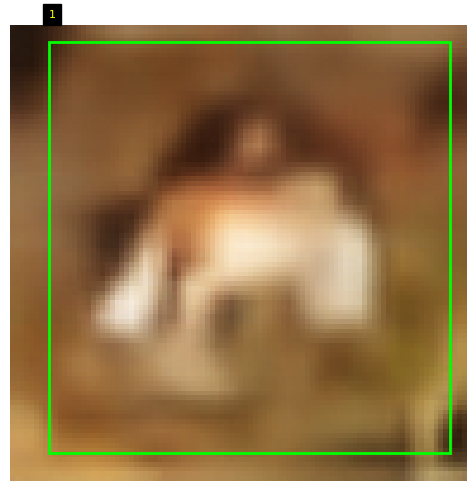

Image 2


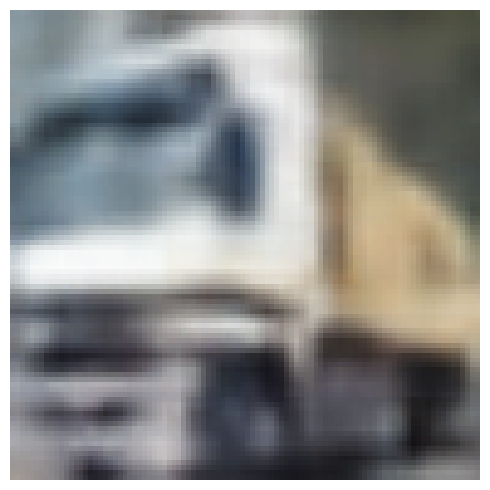

Image 3


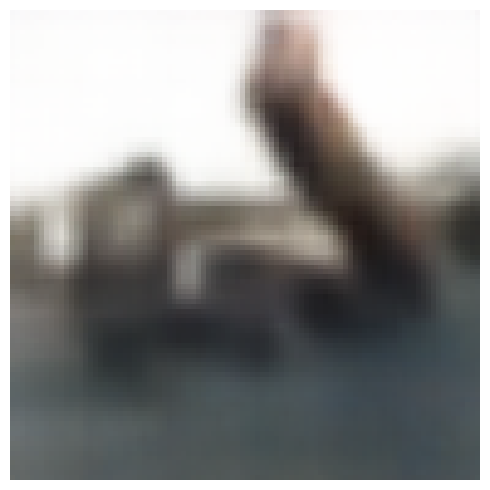

Image 4


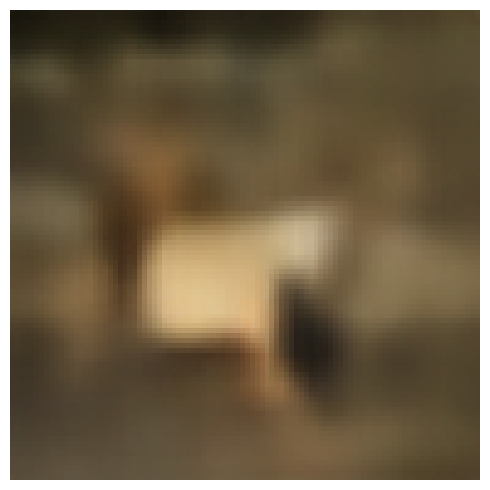

Image 5


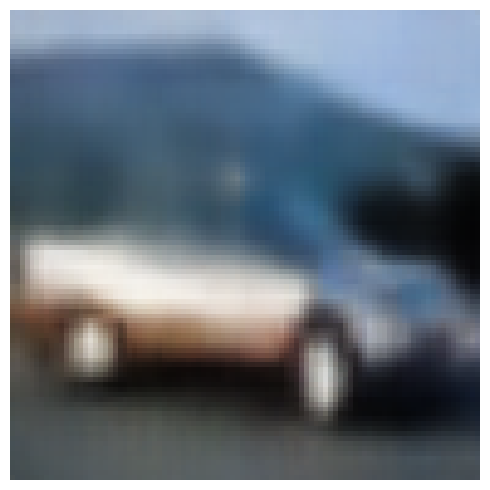

In [ ]:
# --- PyTorch Object Detection on VAE-Generated Images ---
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Convert TensorFlow VAE outputs to PyTorch tensors
def convert_to_torch(decoded_imgs):
    # Rescale from [-1, 1] to [0, 1], then to [C, H, W]
    imgs = (decoded_imgs + 1.0) / 2.0
    imgs = torch.from_numpy(imgs).permute(0, 3, 1, 2).float()
    return imgs

torch_imgs = convert_to_torch(decoded_imgs).to(device)

# Step 2: Load pretrained Faster R-CNN
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights).to(device)
model.eval()

# Step 3: Inference on each generated image
@torch.no_grad()
def detect_objects(model, images, threshold=0.5):
    preds = model(list(images))
    return [
        {
            'boxes': p['boxes'][p['scores'] > threshold],
            'labels': p['labels'][p['scores'] > threshold],
            'scores': p['scores'][p['scores'] > threshold]
        }
        for p in preds
    ]

detections = detect_objects(model, torch_imgs)

# Step 4: Visualization
def plot_image_with_boxes(image, boxes, labels=None):
    fig, ax = plt.subplots(1, figsize=(5, 5))
    img = image.permute(1, 2, 0).cpu().numpy()
    ax.imshow(img)
    boxes = boxes.cpu()
    if labels is not None:
        labels = labels.cpu()

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        if labels is not None:
            ax.text(x1, y1 - 5, f"{labels[i].item()}", color='yellow', fontsize=8,
                    backgroundcolor='black')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Step 5: Display first 5 detections
for i in range(5):
    print(f"Image {i+1}")
    plot_image_with_boxes(torch_imgs[i], detections[i]['boxes'], detections[i]['labels'])


Generated Image 1


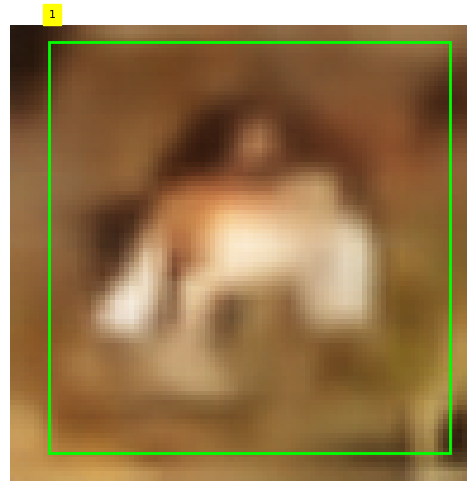

Generated Image 2


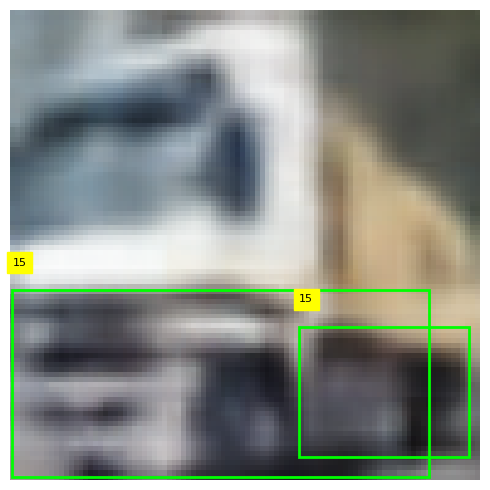

Generated Image 3


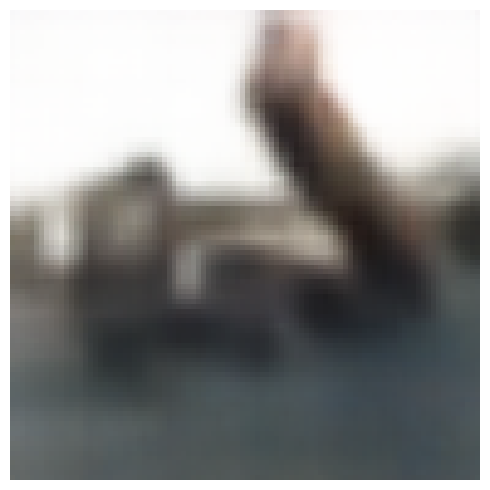

Generated Image 4


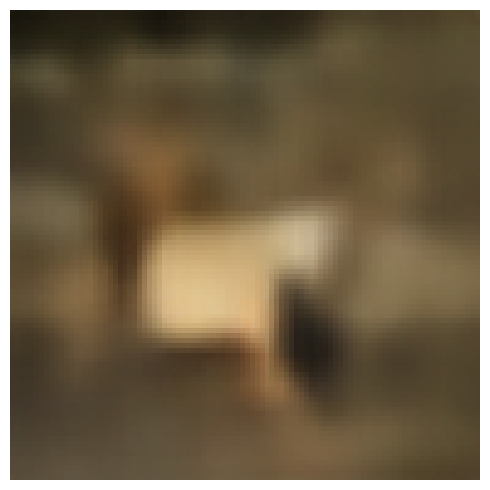

Generated Image 5


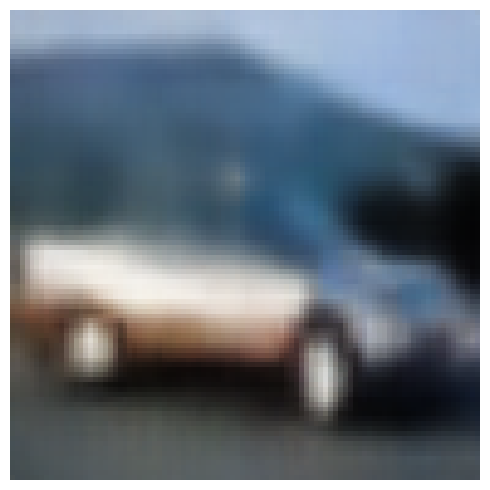

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Convert VAE outputs to torch tensors
def preprocess_generated(decoded_imgs):
    # Convert from [-1, 1] to [0, 1]
    decoded_imgs = (decoded_imgs + 1.0) / 2.0
    # To tensor, permute to [C, H, W]
    torch_imgs = torch.from_numpy(decoded_imgs).permute(0, 3, 1, 2).float()
    return torch_imgs

torch_imgs = preprocess_generated(decoded_imgs).to(device)

# Step 2: Load pre-trained Faster R-CNN (or switch to Mask R-CNN if needed)
def get_faster_rcnn_model(num_classes=91):  # COCO pretrained
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    model.to(device).eval()
    return model

model = get_faster_rcnn_model()

# Step 3: Run detection on VAE outputs
@torch.no_grad()
def detect_objects(model, images, threshold=0.4):
    outputs = model(list(images))
    filtered_outputs = []
    for out in outputs:
        mask = out["scores"] > threshold
        filtered_outputs.append({
            "boxes": out["boxes"][mask],
            "labels": out["labels"][mask],
            "scores": out["scores"][mask]
        })
    return filtered_outputs

detections = detect_objects(model, torch_imgs)

# Step 4: Visualize
def plot_image_with_boxes(image_tensor, boxes, labels=None):
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, figsize=(5, 5))
    ax.imshow(image_np)
    boxes = boxes.cpu()
    if labels is not None:
        labels = labels.cpu()

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        if labels is not None:
            ax.text(x1, y1 - 5, str(labels[i].item()), color='black',
                    fontsize=8, backgroundcolor='yellow')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show first 5 detections
for i in range(min(5, len(detections))):
    print(f"Generated Image {i + 1}")
    plot_image_with_boxes(torch_imgs[i], detections[i]['boxes'], detections[i]['labels'])


In [ ]:
!pip install transformers torch torchvision pillow



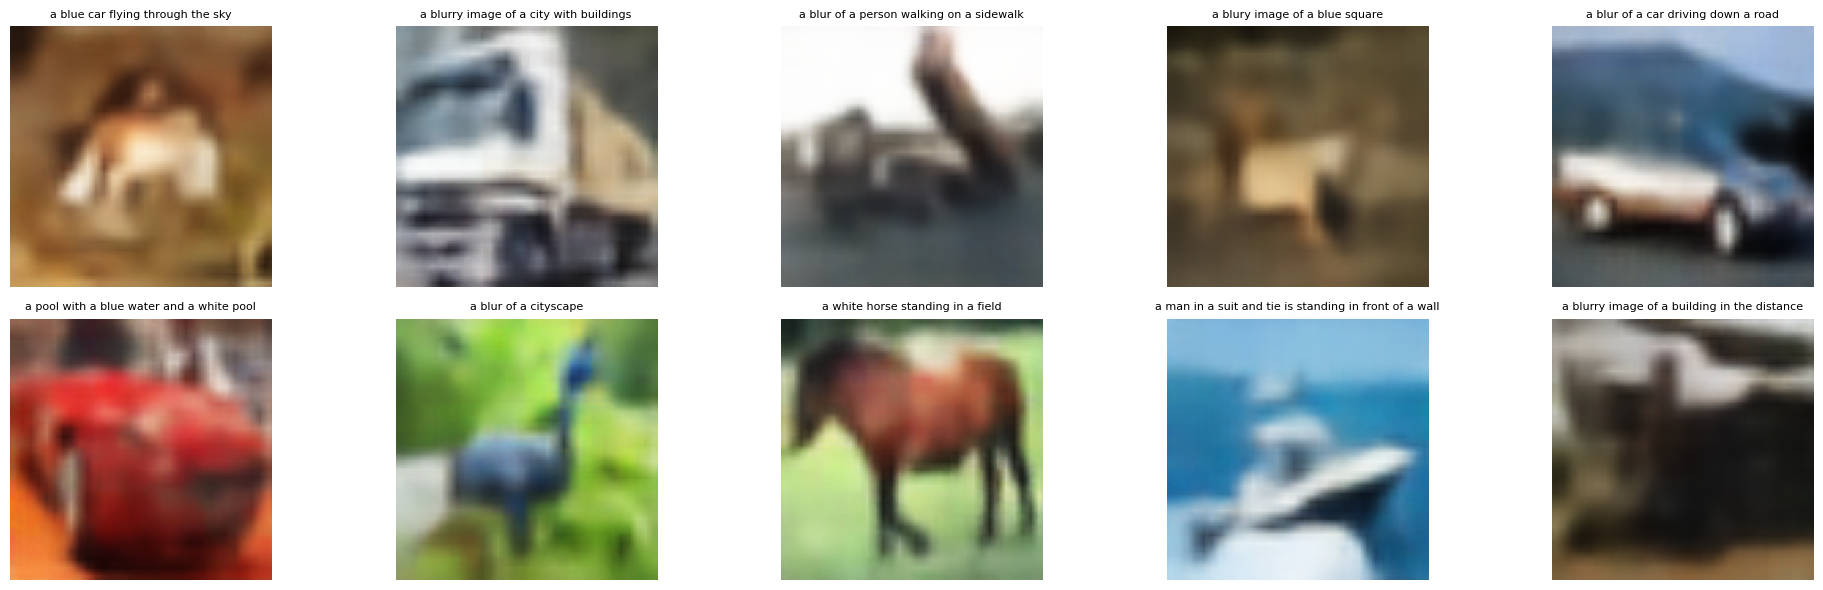

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
# Load pretrained BLIP model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
model.eval()

# Function to caption VAE-generated image
def caption_vae_image(img_np):
    img = (img_np * 255).astype("uint8")  # scale from [0,1] to [0,255]
    image_pil = Image.fromarray(img)
    inputs = processor(images=image_pil, return_tensors="pt")

    with torch.no_grad():
        out = model.generate(**inputs)
        caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

# Convert VAE outputs to [0, 1]
vae_images = (decoded_imgs + 1.0) / 2.0

# Run captioning
captions = [caption_vae_image((vae_images[i] * 255).astype("uint8")) for i in range(10)]

# Visualize
plt.figure(figsize=(20, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(vae_images[i])
    plt.title(captions[i], fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.show()
